In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()

In [5]:
format_plots()

## normalized

In [6]:
# avarage per age or session
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

## pca females

In [7]:
## female
df=f_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [8]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

In [9]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.2338679  0.40836206 0.49996806]


In [10]:
# Create a colormap
#colors = plt.cm.cmf(np.linspace(0, 1, len(pcs)))
from matplotlib.collections import LineCollection
# Create segments for LineCollection
points = np.array([age_pc['PC1'],age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1))
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))

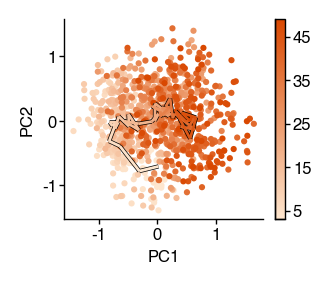

In [11]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.6, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=5,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [5,15,25,35,45]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_female_norm_line_longv2.pdf')

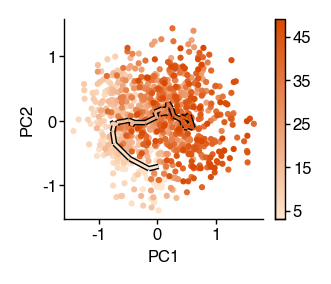

In [13]:
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 2  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['PC1'], df_smooth['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['PC1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.6, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=5,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [5,15,25,35,45]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_female_norm_line_longv2_smoothened.pdf')

0.6715560148583225


/tmp/ipykernel_26644/2376268498.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


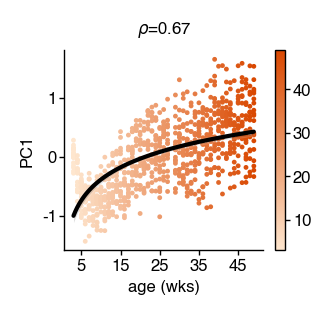

In [15]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.6,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmf)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1', xticks=[5,15,25,35,45])
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

In [16]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_pc1_correlation_female_longv2.pdf')

## pca males

In [17]:
df=m_norm.copy()
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [18]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

In [19]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
print(np.cumsum(variance_explained))
format_plots()

[0.25512857 0.35696346 0.44795667]


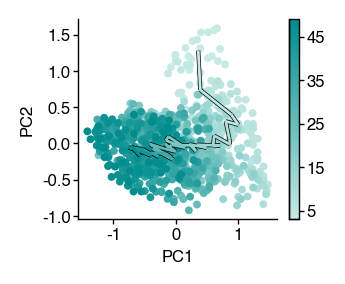

In [20]:
# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=1.5)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.6, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=8,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [5,15,25,35,45]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])
tick_values = [5,15,25,35,45]

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_male_norm_line_longv2.pdf')

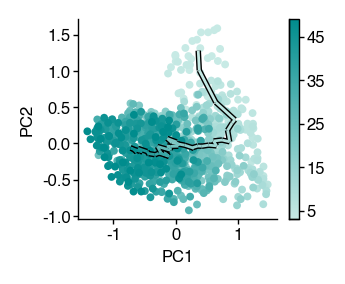

In [22]:
## smoothened line
# Create segments for LineCollection
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 2  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['PC1'], df_smooth['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['PC1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.6, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=8,
    edgecolor='none',
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [5,15,25,35,45]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])
tick_values = [5,15,25,35,45]

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [23]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_male_norm_line_longv2_smoothened.pdf')

-0.7161348132390205


/tmp/ipykernel_26644/3066221256.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


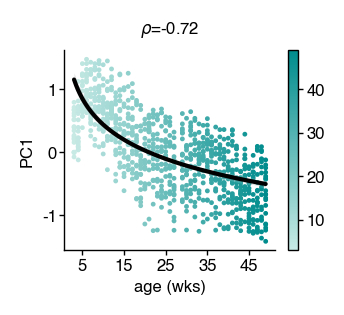

In [24]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)
fig, ax = plt.subplots()
fig.set_size_inches(1.7,1.3) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=3, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,
                )
ax.set(xlabel='age (wks)', ylabel='PC1', xticks=[5,15,25,35,45])
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
tick_values = [5,15,25,35,45]
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

In [25]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'PCA_pc1_correlation_male_longv2.pdf')